# Importing Packages

In [58]:
!pip install einops

In [59]:
import cv2
import os
import json
import glob
import webcolors
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from einops import rearrange, repeat
from torch.utils.data import Dataset
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, random_split

import optuna
from optuna.trial import Trial

# Data Preprocessing

In [60]:
# Load dataset
image_directory = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'
image_ids = os.listdir(image_directory)
df = pd.read_csv("/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv", on_bad_lines='skip',index_col=False)

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

display(df)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [61]:
# List of IDs to delete
ids_to_delete = [39403, 39410, 39401, 39425, 12347]

# Remove rows with the specified IDs
df = df[~df['id'].isin(ids_to_delete)].reset_index(drop=True)

# Convert 'id' column to a list
ls = list(df['id'])

# Create full paths with .jpg extension and update the DataFrame
df['id'] = [os.path.join(image_directory, f"{str(id)}.jpg") for id in ls]

In [62]:
def get_unique_val(dataframe):
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        unique_count = len(unique_values)
        print(f"Column: {column}, Unique Values Count: {unique_count}")
        print(f"Unique Values: {unique_values}\n")

In [63]:
# drop unused features
df = df.drop(columns=["articleType","year","productDisplayName"])

# rename feature for ease of use
df = df.rename(columns={'id': 'imagePath','usage': 'style','baseColour': 'color'})

# Drop rows with NaN values and then remove duplicates
df = df.dropna().drop_duplicates()
get_unique_val(df)

Column: imagePath, Unique Values Count: 44074
Unique Values: ['/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/15970.jpg'
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/39386.jpg'
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/59263.jpg'
 ...
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/18842.jpg'
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/46694.jpg'
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/51623.jpg']

Column: gender, Unique Values Count: 5
Unique Values: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']

Column: masterCategory, Unique Values Count: 7
Unique Values: ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']

Column: subCategory, Unique Values Count: 45
Unique Values: ['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewel

In [64]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [65]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [66]:
def analyze_dataframe(df, save_dir=None):
    """
    Analyzes a given DataFrame by plotting the number of values in each class for each feature using Plotly.
    Optionally, saves the plot as an HTML file in the specified directory.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame to analyze.
    save_dir (str, optional): Directory to save the plot as an HTML file. If None, the plot will not be saved.
    
    Returns:
    None
    """
    num_cols = len(df.columns)
    fig = make_subplots(rows=num_cols, cols=1, 
                        subplot_titles=[f"Distribution of values in '{col}'" for col in df.columns],
                        vertical_spacing=0.1)
    
    for i, col in enumerate(df.columns, start=1):
        # Count the number of values in each class
        class_counts = df[col].value_counts()
        
        # Create bar chart for each feature
        fig.add_trace(
            go.Bar(
                x=class_counts.index,
                y=class_counts.values,
                text=[f"{class_counts[col]}" for col in class_counts.index],
                textposition='auto',
                marker=dict(color='#1f77b4')
            ),
            row=i, col=1
        )
        
        # Update layout for each subplot
        fig.update_xaxes(title_text="Class", row=i, col=1, tickangle=45)
        fig.update_yaxes(title_text="Count", row=i, col=1)

    fig.update_layout(
        title_text="Feature-wise Class Distribution",
        height=400 * num_cols,
        showlegend=False
    )
    
    # Save the plot if save_dir is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_path = os.path.join(save_dir, "class_distribution_plot.html")
        fig.write_html(file_path)
        print(f"Plot saved as {file_path}")
    
    # Display the plot
    fig.show()

# Example usage
# analyze_dataframe(df.drop(columns=["imagePath"]), save_dir="/kaggle/working/")


In [67]:
df.describe()

,imagePath,gender,masterCategory,subCategory,color,season,style
count,44074,44074,44074,44074,44074,44074,44074
unique,44074,5,7,45,46,4,8
top,/kaggle/input/fashion-product-images-dataset/f...,Men,Apparel,Topwear,Black,Summer,Casual
freq,1,22104,21361,15383,9699,21440,34394


Category: Accessories, Subcategory: Bags, Color: Orange


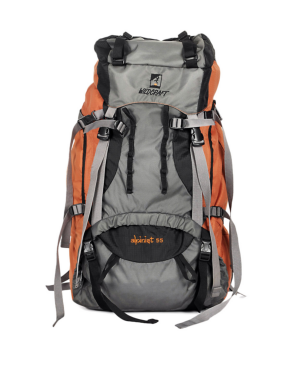

Category: Accessories, Subcategory: Bags, Color: Brown


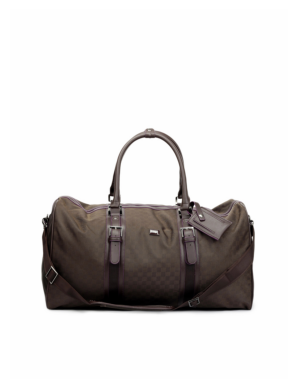

Category: Apparel, Subcategory: Topwear, Color: Purple


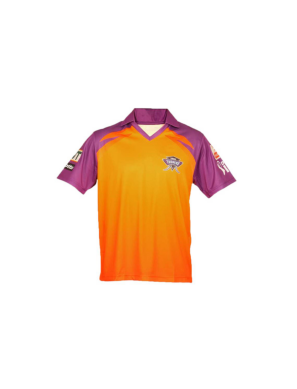

Category: Accessories, Subcategory: Bags, Color: Blue


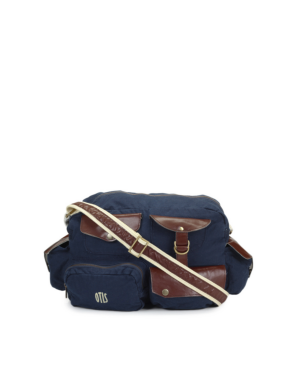

Category: Accessories, Subcategory: Bags, Color: Red


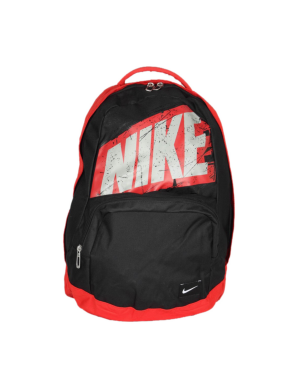

In [68]:
# Filter for unisex items
unisex_df = df[df['gender'] == 'Unisex'].drop_duplicates()

# Display sample images (e.g., first 5)
sample_unisex_df = unisex_df.sample(n=5) if len(unisex_df) >= 5 else unisex_df

# Display the images
for _, row in sample_unisex_df.iterrows():
    # Open image using PIL
    image = Image.open(row['imagePath'])
    
    # Print image details
    print(f"Category: {row['masterCategory']}, Subcategory: {row['subCategory']}, Color: {row['color']}")
    
    # Display the image
    plt.figure()
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

## Convert Colors Categorical values into RGB (Classification -> Regression)

In [69]:
# Example: Convert color name to RGB
def color_to_rgb(color_name):
    try:
        return webcolors.name_to_rgb(color_name)
    except ValueError:
        return None

# Sample color conversion
df['rgb'] = df['color'].apply(color_to_rgb)

In [70]:
# Find unique rows where conversion resulted in None
invalid_colors = df[df['rgb'].isnull()]['color'].unique()

# Display the unique invalid colors
print("Unique colors that resulted in None (invalid colors):")
print(invalid_colors)

Unique colors that resulted in None (invalid colors):
['Navy Blue' 'Bronze' 'Copper' 'Off White' 'Charcoal' 'Steel' 'Multi'
 'Sea Green' 'Cream' 'Peach' 'Skin' 'Burgundy' 'Coffee Brown'
 'Grey Melange' 'Rust' 'Rose' 'Lime Green' 'Mauve' 'Turquoise Blue'
 'Metallic' 'Mustard' 'Taupe' 'Nude' 'Mushroom Brown' 'Fluorescent Green']


In [71]:
# Define the dictionary with RGB values for invalid colors
colors_rgb = {
    'Navy Blue': (0, 0, 128),   # A deep, dark shade of blue
    'Bronze': (205, 127, 50),   # A metallic brown shade
    'Copper': (184, 115, 51),   # A reddish-brown metallic tone
    'Off White': (255, 255, 240), # A slight shade off pure white
    'Charcoal': (54, 69, 79),   # A dark grey shade
    'Steel': (70, 130, 180),    # A medium blue-grey shade
    'Sea Green': (46, 139, 87), # A medium green-blue tone
    'Cream': (255, 253, 208),   # A light, yellowish-white shade
    'Peach': (255, 218, 185),   # A light pink-orange tone
    'Skin': (255, 224, 189),    # A common shade for skin tone
    'Burgundy': (128, 0, 32),   # A deep red-brown tone
    'Coffee Brown': (111, 78, 55), # A dark brown color
    'Grey Melange': (169, 169, 169), # A light grey, similar to silver
    'Rust': (183, 65, 14),      # A reddish-brown color
    'Rose': (255, 0, 127),      # A bright pink-red color
    'Lime Green': (50, 205, 50), # A bright green tone
    'Mauve': (224, 176, 255),   # A pale purple color
    'Turquoise Blue': (0, 255, 239), # A bright blue-green tone
    'Mustard': (255, 219, 88),  # A dark yellow shade
    'Taupe': (72, 60, 50),      # A brown-grey color
    'Nude': (228, 193, 160),    # A skin-tone like shade
    'Mushroom Brown': (176, 154, 149), # A muted brown tone
    'Fluorescent Green': (8, 255, 8), # A very bright green shade
    'Metallic' : (142, 142, 142), # very close to silver
    'Multi': (157, 12, 255)
}

# Replace None values in the 'rgb' column using the colors_rgb dictionary
df['rgb'] = df.apply(lambda row: colors_rgb.get(row['color'], row['rgb']), axis=1)

# Separate the 'rgb' column into three columns: 'R', 'G', 'B'
df[['R', 'G', 'B']] = pd.DataFrame(df['rgb'].to_list(), index=df.index)

# Drop the original 'rgb' column if no longer needed
df = df.drop(['rgb', 'color'], axis=1)

## Encoding Data using OHE and Binary encoder 

In [104]:
# Defining features to encode
one_hot_features = ['gender', 'season']
binary_features = ['subCategory', 'masterCategory', 'style']


# OneHotEncoder for features with low cardinality
one_hot = OneHotEncoder(drop='first', sparse_output=False)

# BinaryEncoder for features with high cardinality
binary = BinaryEncoder()

# Creating the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', one_hot, one_hot_features),
        ('binary', binary, binary_features)
    ],
    remainder='passthrough'  # Keep other columns as is
)

# Fit and transform the data
encoded_data = preprocessor.fit_transform(df)

# Convert back to DataFrame for better visualization
encoded_df = pd.DataFrame(encoded_data, columns=preprocessor.get_feature_names_out())
encoded_df

,onehot__gender_Girls,onehot__gender_Men,onehot__gender_Unisex,onehot__gender_Women,onehot__season_Spring,onehot__season_Summer,onehot__season_Winter,binary__subCategory_0,binary__subCategory_1,binary__subCategory_2,...,binary__masterCategory_1,binary__masterCategory_2,binary__style_0,binary__style_1,binary__style_2,binary__style_3,remainder__imagePath,remainder__R,remainder__G,remainder__B
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,1,0,0,0,1,/kaggle/input/fashion-product-images-dataset/f...,0,0,128
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,...,0,1,0,0,0,1,/kaggle/input/fashion-product-images-dataset/f...,0,0,255
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0,...,1,0,0,0,0,1,/kaggle/input/fashion-product-images-dataset/f...,192,192,192
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,1,0,0,0,1,/kaggle/input/fashion-product-images-dataset/f...,0,0,0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,...,0,1,0,0,0,1,/kaggle/input/fashion-product-images-dataset/f...,128,128,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44069,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,...,1,1,0,0,0,1,/kaggle/input/fashion-product-images-dataset/f...,255,255,255
44070,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,...,1,1,0,0,0,1,/kaggle/input/fashion-product-images-dataset/f...,255,0,0
44071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,1,0,0,0,1,/kaggle/input/fashion-product-images-dataset/f...,0,0,255
44072,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,1,...,0,0,0,0,0,1,/kaggle/input/fashion-product-images-dataset/f...,0,0,255


In [105]:
# def clean_column_name(col_name):
#     # Remove unnecessary prefixes
#     col_name = col_name.replace('onehot__', '')
#     col_name = col_name.replace('binary__', '')
#     col_name = col_name.replace('remainder__', '')

#     # Optionally, replace double underscores with a single underscore
#     col_name = col_name.replace('__', '_')
    
#     return col_name
    
# # Apply the cleaning function to all column names
# encoded_df.columns = [clean_column_name(col) for col in encoded_df.columns]
# encoded_df

In [106]:
# Exclude non-numeric columns such as 'remainder__imagePath' before conversion
columns_to_convert = [
    col for col in encoded_df.columns if col != 'remainder__imagePath'
]

# Convert selected columns to float32
encoded_df[columns_to_convert] = encoded_df[columns_to_convert].astype(np.float32)

# Check the updated data types
print(encoded_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44074 entries, 0 to 44073
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   onehot__gender_Girls      44074 non-null  float32
 1   onehot__gender_Men        44074 non-null  float32
 2   onehot__gender_Unisex     44074 non-null  float32
 3   onehot__gender_Women      44074 non-null  float32
 4   onehot__season_Spring     44074 non-null  float32
 5   onehot__season_Summer     44074 non-null  float32
 6   onehot__season_Winter     44074 non-null  float32
 7   binary__subCategory_0     44074 non-null  float32
 8   binary__subCategory_1     44074 non-null  float32
 9   binary__subCategory_2     44074 non-null  float32
 10  binary__subCategory_3     44074 non-null  float32
 11  binary__subCategory_4     44074 non-null  float32
 12  binary__subCategory_5     44074 non-null  float32
 13  binary__masterCategory_0  44074 non-null  float32
 14  binary

In [107]:
# Function to resize while maintaining aspect ratio and adding padding
def resize_with_padding(image, target_size=(224, 224)):
    # Get original dimensions
    width, height = image.size
    target_width, target_height = target_size
    
    # Calculate the aspect ratio
    aspect_ratio = width / height
    
    # Resize the image to fit the target size while maintaining aspect ratio
    if aspect_ratio > 1:  # Image is wider than tall
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:  # Image is taller than wide
        new_height = target_height
        new_width = int(target_height * aspect_ratio)
    
    # Resize image
    image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Calculate padding (for width and height)
    pad_left = (target_width - new_width) // 2
    pad_right = target_width - new_width - pad_left
    pad_top = (target_height - new_height) // 2
    pad_bottom = target_height - new_height - pad_top
    
    # Apply padding to the image
    image = transforms.functional.pad(image, (pad_left, pad_top, pad_right, pad_bottom), fill=255)  # White padding
    
    return image


# Create Datasets and DataLaoders

In [114]:
from typing import Tuple, Optional, Literal

class FashionDataset(Dataset):
    """
    Custom Dataset for Fashion data that includes categorical features, RGB values, and images
    """
    def __init__(self, 
                 dataframe: pd.DataFrame, 
                 image_dir: str,
                 split: Literal['train', 'val', 'test'],
                 transform=None) -> None:
        """
        Args:
            dataframe (pd.dataframe): The required dataframe
            image_dir (str): Directory containing the images
            split (str): One of 'train', 'val', or 'test'
            transform (callable, optional): Optional transform to be applied on the data
        """
        self.data = dataframe.copy()  # Create a copy to avoid modifying original
        self.image_dir = image_dir
        self.transform = transforms.Compose([
            transforms.Lambda(lambda img: resize_with_padding(img, target_size=(224, 224))),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
        ])

        # Define task-specific column groups based on column name patterns
        self.gender_cols = [col for col in self.data.columns if 'gender_' in col]
        self.season_cols = [col for col in self.data.columns if 'season_' in col]
        self.subcat_cols = [col for col in self.data.columns if 'subCategory_' in col]
        self.mastercat_cols = [col for col in self.data.columns if 'masterCategory_' in col]
        self.style_cols = [col for col in self.data.columns if 'style_' in col]
        self.color_cols = ['remainder__R', 'remainder__G', 'remainder__B']

        # Ensure all feature columns are properly converted to numeric
        for col_group in [self.gender_cols, self.season_cols, self.subcat_cols, 
                          self.mastercat_cols, self.style_cols]:
            for col in col_group:
                self.data[col] = pd.to_numeric(self.data[col], errors='coerce').fillna(0).astype(np.float32)
        
        # Ensure color columns are converted to numeric
        for col in self.color_cols:
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce').fillna(0).astype(np.float32)


        # Create indices for train/val/test splits using sklearn
        indices = np.arange(len(self.data))
        
        # First split: 70% train, 30% temp (which will be split into val and test)
        train_indices, temp_indices = train_test_split(
            indices, 
            train_size=0.8,
            random_state=42
        )
        
        # Second split: Split the remaining 30% into 20% val and 10% test
        # This is a 2/3 (val) and 1/3 (test) split of the temporary indices
        val_indices, test_indices = train_test_split(
            temp_indices,
            train_size=0.5,  
            random_state=42
        )
        
        if split == 'train':
            self.indices = train_indices
        elif split == 'val':
            self.indices = val_indices
        else:  # test
            self.indices = test_indices

    def __len__(self) -> int:
        return len(self.indices)

    def load_image(self, image_path: str) -> torch.Tensor:
        """
        Load and preprocess image
        """
        try:
            # Extract filename from full path in CSV
            filename = os.path.basename(image_path)
            full_path = os.path.join(self.image_dir, filename)
            
            # Load and convert image
            image = Image.open(full_path).convert('RGB')
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
                
            return image
        
        except Exception as e:
            print(f"Error loading image {image_path}: {str(e)}")
            # Return a blank image in case of error
            return torch.zeros((3, 224, 224))

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, 
                                            torch.Tensor, torch.Tensor, torch.Tensor,
                                            torch.Tensor]:
        """
        Returns a tuple of tensors containing:
        - Image tensor
        - Gender features
        - Season features
        - Subcategory features
        - Master category features
        - Style features
        - RGB values
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        real_idx = self.indices[idx]
        
        # Load image
        image_path = self.data.iloc[real_idx]['remainder__imagePath']
        image = self.load_image(image_path)
        
        # Extract feature groups and convert to tensors
        gender = torch.tensor(self.data.iloc[real_idx][self.gender_cols].values.astype(np.float32), dtype=torch.float32)
        season = torch.tensor(self.data.iloc[real_idx][self.season_cols].values.astype(np.float32), dtype=torch.float32)
        subcat = torch.tensor(self.data.iloc[real_idx][self.subcat_cols].values.astype(np.float32), dtype=torch.float32)
        mastercat = torch.tensor(self.data.iloc[real_idx][self.mastercat_cols].values.astype(np.float32), dtype=torch.float32)
        style = torch.tensor(self.data.iloc[real_idx][self.style_cols].values.astype(np.float32), dtype=torch.float32)
        color = torch.tensor(self.data.iloc[real_idx][self.color_cols].values.astype(np.float32), dtype=torch.float32) / 255.0
            
        return image, gender, season, subcat, mastercat, style, color


## Data loaders and parameters

In [115]:
def get_dataloaders(dataframe: pd.DataFrame,
                    image_dir: str,
                    batch_size: int = 32, 
                    num_workers: int = 0,
                    transform: Optional[callable] = None) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Creates and returns train, validation, and test dataloaders
    
    Args:
        dataframe (pd.DataFrame): DataFrame containing the dataset
        image_dir (str): Directory containing the images
        batch_size (int): Batch size for the dataloader
        num_workers (int): Number of workers for the dataloader
        transform (callable, optional): Optional transform to be applied on the data
        
    Returns:
        tuple: (train_dataloader, val_dataloader, test_dataloader)
    """
    # Create datasets
    train_dataset = FashionDataset(dataframe, image_dir, split='train', transform=transform)
    val_dataset = FashionDataset(dataframe, image_dir, split='val', transform=transform)
    test_dataset = FashionDataset(dataframe, image_dir, split='test', transform=transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader


In [116]:
if __name__ == "__main__":
    # Create dataloaders
    train_loader, val_loader, test_loader = get_dataloaders(
        dataframe=encoded_df,
        image_dir=image_directory,
        batch_size=32,
        num_workers=4
    )
    
    # Example of iterating through the dataloader
    for batch in train_loader:
        image, gender, season, subcat, mastercat, style, color = batch
        # Your training loop here
        break  # Just showing first batch
        
    print(f"Image shape: {image.shape}")  # Should be [batch_size, 3, 224, 224]
    print(f"Gender shape: {gender.shape}")
    print(f"Season shape: {season.shape}")
    print(f"Subcategory shape: {subcat.shape}")
    print(f"Master category shape: {mastercat.shape}")
    print(f"Style shape: {style.shape}")
    print(f"Color shape: {color.shape}")

Image shape: torch.Size([32, 3, 224, 224])
Gender shape: torch.Size([32, 4])
Season shape: torch.Size([32, 3])
Subcategory shape: torch.Size([32, 6])
Master category shape: torch.Size([32, 3])
Style shape: torch.Size([32, 4])
Color shape: torch.Size([32, 3])


In [ ]:
import random

def get_random_sample(dataloader):
    # Get total number of samples in the dataset
    total_samples = len(dataloader.dataset)
    
    # Generate a random index
    random_idx = random.randint(0, total_samples - 1)
    
    # Convert to iterator
    dataiter = iter(dataloader)
    
    # Get the batch index and position within batch
    batch_idx = random_idx // dataloader.batch_size
    pos_in_batch = random_idx % dataloader.batch_size
    
    # Skip to the random batch
    for _ in range(batch_idx):
        next(dataiter)
    
    # Get the random batch
    batch = next(dataiter)
    image, gender, season, subcat, mastercat, style, color = batch
    
    # Extract the random sample from the batch
    random_sample = {
        'image': image[pos_in_batch],
        'gender': gender[pos_in_batch],
        'season': season[pos_in_batch],
        'subcat': subcat[pos_in_batch],
        'mastercat': mastercat[pos_in_batch],
        'style': style[pos_in_batch],
        'color': color[pos_in_batch]
    }
    
    return random_sample

# # Get a random sample
# random_sample = get_random_sample(test_loader)

# # Display the image
# plt.figure(figsize=(8, 8))
# # Convert tensor to numpy and transpose from (C,H,W) to (H,W,C)
# img = random_sample['image'].permute(1, 2, 0).numpy()
# # Denormalize if your images were normalized
# # img = img * std + mean  # Uncomment and adjust if needed
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# # Print the labels
# print(f"Gender: {random_sample['gender']}")
# print(f"Season: {random_sample['season']}")
# print(f"Subcategory: {random_sample['subcat']}")
# print(f"Master category: {random_sample['mastercat']}")
# print(f"Style: {random_sample['style']}")
# print(f"Color: {random_sample['color']}")

In [ ]:
# To get the total number of samples in each loader
print(f"\nNumber of samples in train set: {len(train_loader.dataset)}")
print(f"Number of samples in validation set: {len(val_loader.dataset)}")
print(f"Number of samples in test set: {len(test_loader.dataset)}")

# To verify the splits (should be approximately 70/20/10)
total_samples = len(train_loader.dataset) + len(val_loader.dataset) + len(test_loader.dataset)
print(f"\nSplit proportions:")
print(f"Train: {len(train_loader.dataset)/total_samples:.2%}")
print(f"Val: {len(val_loader.dataset)/total_samples:.2%}")
print(f"Test: {len(test_loader.dataset)/total_samples:.2%}")

# Building Vision Transformer Vit

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        
        self.projection = nn.Sequential(
            # Convert image into patches and flatten
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
                     p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        )
        
        # Learnable classification token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        # Learnable position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        b = x.shape[0]  # batch size
        x = self.projection(x)
        
        # Add classification token to each sequence
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Add positional embedding
        x = x + self.pos_embedding
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        b, n, c = x.shape
        qkv = self.qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads), qkv)
        
        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        
        x = attn @ v
        x = rearrange(x, 'b h n d -> b n (h d)')
        x = self.proj(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))
        x = x + self.dropout(self.mlp(self.norm2(x)))
        return x

In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, num_classes, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, num_classes)
        )
    
    def forward(self, x):
        # Use only the [CLS] token
        x = x[:, 0]
        x = self.norm(x)
        return self.head(x)

class RegressionHead(nn.Module):
    def __init__(self, embed_dim, output_dim=3, dropout=0.2):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, output_dim)  # Output RGB values
        )
    
    def forward(self, x):
        x = x[:, 0]
        x = self.norm(x)
        return self.head(x)

In [ ]:
class Head(nn.Module):
    def __init__(self, embed_dim, output_dim, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, output_dim)
        )
    
    def forward(self, x):
        # Use only the [CLS] token
        x = x[:, 0]
        x = self.norm(x)
        return self.head(x)

In [ ]:
class FashionViT(nn.Module):
    def __init__(self,
        image_size=224, patch_size=16, in_channels=3, embed_dim=768,
        num_layers=12, num_heads=12, mlp_ratio=4.0, dropout=0.1,
        num_classes_dict={
            'gender': 4,
            'season': 3,
            'subcat': 6,
            'mastercat': 3,
            'style': 4} ):
        
        super().__init__()
        self.patch_embed = PatchEmbedding(
            image_size=image_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        # Transformer encoder
        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])
        
        # Classification heads
        self.heads = nn.ModuleDict({
            task: Head(embed_dim, output_dim=num_classes)
            for task, num_classes in num_classes_dict.items()
        })
        
        # Add regression head for color task
        self.heads['color'] = Head(embed_dim, output_dim=3)

        # Move model to device
        self.to(DEVICE)
        
    def forward(self, x):
        x = self.patch_embed(x)
        
        for block in self.transformer:
            x = block(x)
        
        return {task: head(x) for task, head in self.heads.items()}


## Loss function: Focal loss + CE or MSE

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Focal Loss implementation
        
        Args:
            alpha (float): Weighting factor in range (0,1) to balance positive vs negative examples
            gamma (float): Focusing parameter that reduces the relative loss for well-classified examples
            reduction (str): 'mean' or 'sum'
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets.argmax(dim=1), reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class MultitaskLoss(nn.Module):
    def __init__(self, tasks, focal_params=None):
        """
        Multitask loss with Focal Loss for classification tasks
        
        Args:
            tasks (list): List of task names
            focal_params (dict): Dictionary of focal loss parameters for each task
                               Format: {task_name: {'alpha': float, 'gamma': float}}
        """
        super().__init__()
        self.tasks = tasks
        
        # Initialize focal loss parameters with defaults if not provided
        if focal_params is None:
            focal_params = {task: {'alpha': 1.0, 'gamma': 2.0} for task in tasks}
        
        # Create loss functions for each task
        self.loss_functions = {}
        for task in tasks:
            if task == 'color':
                self.loss_functions[task] = nn.MSELoss()
            else:
                params = focal_params.get(task, {'alpha': 1.0, 'gamma': 2.0})
                self.loss_functions[task] = FocalLoss(
                    alpha=params['alpha'],
                    gamma=params['gamma']
                )
        
        # Learnable task weights
        self.log_vars = nn.Parameter(torch.zeros(len(tasks)))
        
        # Move to device
        self.to(DEVICE)
    
    def forward(self, predictions, targets):
        total_loss = 0
        losses = {}
        
        for i, task in enumerate(self.tasks):
            pred = predictions[task]
            target = targets[task]
            
            # Calculate loss using appropriate loss function
            loss = self.loss_functions[task](pred, target)
            
            # Apply learned task weights
            precision = torch.exp(-self.log_vars[i])
            weighted_loss = precision * loss + self.log_vars[i]
            
            total_loss += weighted_loss
            losses[task] = loss.item()
        
        return total_loss, losses

# Example usage:
"""
# Define focal loss parameters for each task (optional)
focal_params = {
    'gender': {'alpha': 0.25, 'gamma': 2.0},
    'season': {'alpha': 0.25, 'gamma': 2.0},
    'subcat': {'alpha': 0.25, 'gamma': 2.0},
    'mastercat': {'alpha': 0.25, 'gamma': 2.0},
    'style': {'alpha': 0.25, 'gamma': 2.0}
}

# Initialize loss function
loss_fn = MultitaskLoss(
    tasks=['gender', 'season', 'subcat', 'mastercat', 'style', 'color'],
    focal_params=focal_params
)
"""

## train step and validation

In [ ]:
def train_step(model, optimizer, loss_fn, batch):
    model.train()
    
    # Move batch to device
    image, gender, season, subcat, mastercat, style, color = [x.to(DEVICE) for x in batch]
    
    # Forward pass
    predictions = model(image)
    
    # Prepare targets dictionary
    targets = {
        'gender': gender,
        'season': season,
        'subcat': subcat,
        'mastercat': mastercat,
        'style': style,
        'color': color
    }
    
    # Calculate loss
    loss, task_losses = loss_fn(predictions, targets)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), task_losses

def validate(model, val_loader, loss_fn):
    model.eval()
    total_loss = 0
    # Separate metrics tracking for classification tasks and regression task
    task_metrics = {task: {'tp': [], 'fp': [], 'fn': [], 'tn': []} 
                   for task in model.heads.keys() if task != 'color'}
    
    # Special tracking for color regression
    color_predictions = []
    color_targets = []
    
    # Track classification predictions and targets
    class_preds = []
    class_targets = []
    
    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            image, gender, season, subcat, mastercat, style, color = [x.to(DEVICE) for x in batch]
            
            predictions = model(image)
            
            targets = {
                'gender': gender,
                'season': season,
                'subcat': subcat,
                'mastercat': mastercat,
                'style': style,
                'color': color
            }
            
            loss, _ = loss_fn(predictions, targets)
            total_loss += loss.item()
            
            # Handle classification tasks
            for task in task_metrics.keys():
                pred = predictions[task].argmax(dim=1)
                target = targets[task].argmax(dim=1)
                
                # Store predictions and targets for overall classification metrics
                class_preds.extend(pred.cpu().numpy())
                class_targets.extend(target.cpu().numpy())
                
                # Calculate per-class metrics
                num_classes = predictions[task].size(1)
                for cls in range(num_classes):
                    tp = ((pred == cls) & (target == cls)).sum().item()
                    fp = ((pred == cls) & (target != cls)).sum().item()
                    fn = ((pred != cls) & (target == cls)).sum().item()
                    tn = ((pred != cls) & (target != cls)).sum().item()
                    
                    task_metrics[task]['tp'].append(tp)
                    task_metrics[task]['fp'].append(fp)
                    task_metrics[task]['fn'].append(fn)
                    task_metrics[task]['tn'].append(tn)
            
            # Handle color regression task
            color_pred = predictions['color']  # Assuming this is now continuous values
            color_target = targets['color']
            color_predictions.extend(color_pred.cpu().numpy())
            color_targets.extend(color_target.cpu().numpy())
    
    # Calculate average loss
    avg_loss = total_loss / len(val_loader)
    
    # Calculate F1 scores for classification tasks
    f1_scores = {}
    for task, metrics in task_metrics.items():
        tp = sum(metrics['tp'])
        fp = sum(metrics['fp'])
        fn = sum(metrics['fn'])
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        f1_scores[task] = {
            'f1': f1,
        }
    
    # Calculate R² for color regression
    color_predictions = np.array(color_predictions)
    color_targets = np.array(color_targets)
    
    # Calculate R² score
    ss_tot = np.sum((color_targets - np.mean(color_targets)) ** 2)
    ss_res = np.sum((color_targets - color_predictions) ** 2)
    r2_score = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # Calculate micro and weighted F1 scores for classification tasks only
    class_preds = torch.tensor(class_preds)
    class_targets = torch.tensor(class_targets)
    
    tp_micro = sum(sum(m['tp']) for m in task_metrics.values())
    fp_micro = sum(sum(m['fp']) for m in task_metrics.values())
    fn_micro = sum(sum(m['fn']) for m in task_metrics.values())
    
    micro_precision = tp_micro / (tp_micro + fp_micro) if (tp_micro + fp_micro) > 0 else 0
    micro_recall = tp_micro / (tp_micro + fn_micro) if (tp_micro + fn_micro) > 0 else 0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0
    
    # Calculate weighted F1 for classification tasks
    weights = torch.tensor([len(m['tp']) for m in task_metrics.values()])
    weights = weights / weights.sum()
    weighted_f1 = sum(f1_scores[task]['f1'] * w.item() for task, w in zip(f1_scores.keys(), weights))
    
    # Combine all metrics
    metrics = {
        'loss': avg_loss,
        'task_f1': f1_scores,
        'color_r2': r2_score,  # Add R² score for color regression
        'micro_f1': micro_f1,  # Only for classification tasks
        'weighted_f1': weighted_f1  # Only for classification tasks
    }
    
    return metrics

In [ ]:
def find_checkpoint(checkpoint_type="latest"):
    """
    Find a checkpoint file based on the specified type.

    Args:
        checkpoint_type (str): Type of checkpoint to find, either "latest" or "best".

    Returns:
        str or None: Path to the checkpoint file, or None if no files found.
    """
    checkpoint_files = glob.glob('checkpoint_epoch_*_f1_*.pt')
    if not checkpoint_files:
        return None
    
    if checkpoint_type == "latest":
        # Sort by timestamp (assumes format checkpoint_epoch_X_f1_Y_YYYYMMDD_HHMMSS.pt)
        return max(checkpoint_files, key=lambda x: x.split('_')[-1][:-3])
    
    elif checkpoint_type == "best":
        # Sort by F1 score (assumes format checkpoint_epoch_X_f1_Y_YYYYMMDD_HHMMSS.pt)
        return max(checkpoint_files, key=lambda x: float(x.split('_f1_')[1].split('_')[0]))
    
    else:
        raise ValueError("checkpoint_type must be either 'latest' or 'best'")

In [ ]:
class EarlyStopping:
    """
    Early stopping handler that monitors training progress and stops training
    when specified criteria are met.
    
    Args:
        patience (int): Number of epochs to wait before stopping after criteria are met
        min_delta (float): Minimum change in monitored value to qualify as an improvement
        min_epoch (int): Minimum number of epochs before early stopping can trigger
        verbose (bool): Whether to print early stopping messages
    """
    def __init__(self, patience=5, min_delta=1e-4, min_epoch=10, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.min_epoch = min_epoch
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.best_weighted_f1 = None
        self.early_stop = False
        self.val_loss_min = float('inf')
    
    def __call__(self, val_loss, weighted_f1, epoch):
        if epoch < self.min_epoch:
            return False
            
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_weighted_f1 = weighted_f1
            return False
            
        # Check if validation loss has improved
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        # If validation loss hasn't improved but F1 score has significantly improved
        elif weighted_f1 > self.best_weighted_f1 + self.min_delta:
            self.best_weighted_f1 = weighted_f1
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'Early stopping counter: {self.counter} out of {self.patience}')
        
        if self.counter >= self.patience:
            self.early_stop = True
            if self.verbose:
                print('Early stopping criteria met.')
            return True
            
        return False

In [59]:
def train_fashion_vit(
    train_loader,
    val_loader,
    num_epochs=10,
    learning_rate=1e-5,
    weight_decay=0.05,
    resume_training=False,
    resume_best=False,
    save_dir='/kaggle/working/checkpoints',
    device=None,
    # Early stopping parameters
    patience=5,
    min_delta=1e-4,
    min_epoch=10
):
    """
    Train the FashionViT model with early stopping.
    
    Additional Args:
        patience (int): Number of epochs to wait before early stopping
        min_delta (float): Minimum change in monitored value to qualify as an improvement
        min_epoch (int): Minimum number of epochs before early stopping can trigger
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Use provided device or fall back to global DEVICE
    device = device if device is not None else DEVICE
    print(f"Using device: {device}")
    
    # Initialize model
    model = FashionViT(
        image_size=224,
        patch_size=16,
        in_channels=3,
        embed_dim=768,
        num_layers=12,
        num_heads=12,
        dropout=0.35
    )
    
    # Initialize loss function and optimizer
    tasks = ['gender', 'season', 'subcat', 'mastercat', 'style', 'color']
    loss_fn = MultitaskLoss(tasks)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(
        patience=patience,
        min_delta=min_delta,
        min_epoch=min_epoch
    )
    
    # Training state initialization
    start_epoch = 0
    best_weighted_f1 = 0.0
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_metrics': []
    }
    
    # Resume training if requested
    if resume_training:
        checkpoint_path = find_checkpoint("best") if resume_best else find_checkpoint("latest")
        if checkpoint_path:
            print(f"Resuming training from checkpoint: {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path, map_location=device)
            
            # Load model and optimizer states
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            # Restore training state
            start_epoch = checkpoint['epoch'] + 1
            best_weighted_f1 = checkpoint.get('metrics', {}).get('weighted_f1', 0.0)
            history = checkpoint.get('history', history)
            
            print(f"Restored training state from epoch {start_epoch}")
            print(f"Best weighted F1 score: {best_weighted_f1:.4f}")
        else:
            print("No checkpoint found, starting training from scratch")
    
    # Move model to device
    model = model.to(device)
    
    # Training loop
    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        num_batches = len(train_loader)
        
        for batch_idx, batch in enumerate(train_loader):
            loss, task_losses = train_step(model, optimizer, loss_fn, batch)
            epoch_loss += loss
            
            # Print progress
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - Batch {batch_idx}/{num_batches}")
                print(f"Loss: {loss:.4f}")
                print("Task Losses:")
                for task, task_loss in task_losses.items():
                    print(f"  {task}: {task_loss:.4f}")
                print("-" * 30)
        
        avg_train_loss = epoch_loss / num_batches
        
        # Validation phase
        model.eval()
        metrics = validate(model, val_loader, loss_fn)
        val_loss = metrics['loss']
        weighted_f1 = metrics['weighted_f1']
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_metrics'].append(metrics)
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print("\nTask-specific Metrics:")
        for task, scores in metrics['task_f1'].items():
            print(f"{task}:")
            print(f"  F1: {scores['f1']:.4f}")
        
        # Add color R² score display
        print(f"Color:")
        print(f"  R²: {metrics['color_r2']:.4f}")
        
        print(f"\nOverall Classification Metrics:")
        print(f"Micro F1: {metrics['micro_f1']:.4f}")
        print(f"Weighted F1: {metrics['weighted_f1']:.4f}")
        print("-" * 50)
        
        # Save checkpoint if we got better weighted F1 score
        if metrics['weighted_f1'] > best_weighted_f1:
            best_weighted_f1 = metrics['weighted_f1']
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_train_loss,
                'metrics': metrics,
                'history': history
            }
            
            # Save checkpoint with timestamp
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            checkpoint_path = os.path.join(
                save_dir,
                f'checkpoint_epoch_{epoch+1}_f1_{best_weighted_f1:.4f}_{timestamp}.pt'
            )
            torch.save(checkpoint, checkpoint_path)
            print(f"\nSaved new best model checkpoint: {checkpoint_path}")
        
        # Check early stopping criteria
        if early_stopping(val_loss, weighted_f1, epoch):
            print("\nEarly stopping triggered!")
            print(f"Best validation loss: {early_stopping.best_loss:.4f}")
            print(f"Best weighted F1 score: {early_stopping.best_weighted_f1:.4f}")
            break
        
        # Save training history
        history_path = os.path.join(save_dir, 'training_history.json')
        with open(history_path, 'w') as f:
            json.dump(history, f)
    
    return model, history

## Training loop

In [ ]:
if __name__ == "__main__":
    # Example usage
    model, history = train_fashion_vit(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=10,
        learning_rate=6.631922e-05,
        weight_decay=0.0078858,
        resume_training=False,  # Set to True to resume from checkpoint
        resume_best=False,      # Set to True to resume from best checkpoint
        save_dir='/kaggle/working/checkpoints',
        patience=3,      # Wait 4 epochs before stopping
        min_delta=1e-3,  # Minimum improvement required
        min_epoch=8    # Don't stop before 10 epochs
    )

## Evaluation metrics Plot 

In [ ]:
def plot_training_history(history):
    """
    Plot training history including loss curves and metrics over epochs.
    
    Args:
        history (dict): Dictionary containing training history with keys:
            - 'train_loss': list of training losses
            - 'val_loss': list of validation losses
            - 'val_metrics': list of dictionaries containing validation metrics
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle('Training History', fontsize=14)
    
    # Plot losses
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    
    # Extract metrics
    weighted_f1 = []
    micro_f1 = []
    task_f1s = {
        'gender': [], 'season': [], 'subcat': [], 
        'mastercat': [], 'style': []
    }
    color_r2 = []  # New list for color R² scores
    
    for metric_dict in history['val_metrics']:
        weighted_f1.append(metric_dict['weighted_f1'])
        micro_f1.append(metric_dict['micro_f1'])
        color_r2.append(metric_dict['color_r2'])  # Extract R² score
        
        # Extract individual task F1 scores (excluding color)
        for task, scores in metric_dict['task_f1'].items():
            if task != 'color':  # Skip color as we'll plot R² instead
                task_f1s[task].append(scores['f1'])
    
    # Plot overall metrics
    ax2.plot(epochs, weighted_f1, 'g-', label='Weighted F1')
    ax2.plot(epochs, micro_f1, 'c-', label='Micro F1')
    
    # Plot task-specific F1 scores and color R² with lighter colors
    colors = ['#ff7f7f', '#7fbf7f', '#7f7fff', '#bf7fbf', '#ffbf7f', '#7fffff']
    
    # Plot classification task F1 scores
    for (task, scores), color in zip(task_f1s.items(), colors[:-1]):
        ax2.plot(epochs, scores, color=color, linestyle='--', alpha=0.7, 
                label=f'{task.capitalize()} F1')
    
    # Plot color R² score with the last color
    ax2.plot(epochs, color_r2, color=colors[-1], linestyle='--', alpha=0.7,
            label='Color R²')
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.set_title('Validation Metrics')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    return fig

def save_training_plots(history, save_path):
    """
    Generate and save training history plots.
    
    Args:
        history (dict): Dictionary containing training history
        save_path (str): Path where to save the plot
    """
    fig = plot_training_history(history)
    plt.show()  # Display the plot before saving
    fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close(fig)
    print(f"Saved training plots to: {save_path}")

# Example usage:
with open('checkpoints/training_history.json', 'r') as f:
    history = json.load(f)
# Generate and save plots
save_training_plots(history, '/kaggle/working/__training_plots_acc.png')

In [117]:
def predict_fashion_attributes(
    model,
    image_path,
    preprocessor,
    device=None,
    image_size=224
):
    """
    Predict fashion attributes for a given image using a trained FashionViT model.
    
    Args:
        model (FashionViT): Trained FashionViT model
        image_path (str or PIL.Image): Path to image file or PIL Image object
        preprocessor (ColumnTransformer): Fitted preprocessor containing encoders
        device (torch.device, optional): Device to run inference on
        image_size (int): Size to resize image to (default: 224)
    
    Returns:
        dict: Dictionary containing predictions for each attribute
    """
    # Use provided device or fall back to CPU
    device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Define image preprocessing
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess image
    if isinstance(image_path, str):
        image = Image.open(image_path).convert('RGB')
    else:
        image = image_path.convert('RGB')
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(image_tensor)
        print(type(outputs))
        print(outputs.keys())
    
    # # Process predictions for each task
    predictions = {}
    tasks = ['gender', 'season', 'subCategory', 'masterCategory', 'style', 'color']
    
    # Get the encoders from the preprocessor
    onehot_encoder = preprocessor.named_transformers_['onehot']
    binary_encoder = preprocessor.named_transformers_['binary']
    
    current_idx = 0
    for task in tasks:
        if task == 'color':
            # For color, return RGB values
            color_pred = torch.sigmoid(outputs[current_idx]).cpu().numpy()[0]
            predictions[task] = {
                'rgb': color_pred,
                'hex': '#{:02x}{:02x}{:02x}'.format(
                    int(color_pred[0] * 255),
                    int(color_pred[1] * 255),
                    int(color_pred[2] * 255)
                )
            }
        else:
            output = outputs[task]
            probs = torch.softmax(output, dim=1).cpu().numpy()[0]
            pred_idx = np.argmax(probs)
            confidence = float(probs[pred_idx])
            
            # Create a single-row DataFrame with the predicted index
            pred_df = pd.DataFrame([{task: pred_idx}])

            # Loop through the tasks and apply the prefixes
        # tasks = ['gender', 'season', 'subCategory', 'masterCategory', 'style']
        # for task in tasks:
        #     if task in ['gender', 'season']:
        #         # Apply the onehot__ prefix for gender and season
        #         prefixed_task = f"onehot__{task.capitalize()}"
        
        #         # For OneHotEncoder
        #         feature_names = onehot_encoder.get_feature_names_out([task])
        #         encoded = np.zeros((1, len(feature_names)))
        #         encoded[0, pred_idx] = 1
        #         original_value = onehot_encoder.inverse_transform(encoded)[0][0]
                
        #     elif task in ['subCategory', 'masterCategory', 'style']:
        #         # Apply the binary__ prefix for subCategory, masterCategory, and style
        #         prefixed_task = f"binary__{task}"
        
        #         # For BinaryEncoder
        #         original_value = binary_encoder.inverse_transform(pred_df)[prefixed_task].iloc[0]
        
            
            # Inverse transform based on encoder type
            if task in ['gender', 'season']:
                # For OneHotEncoder
                feature_names = onehot_encoder.get_feature_names_out([task])
                encoded = np.zeros((1, len(feature_names)))
                encoded[0, pred_idx] = 1
                original_value = onehot_encoder.inverse_transform(encoded)[0][0]
            else:
                # For BinaryEncoder
                original_value = binary_encoder.inverse_transform(pred_df)[task].iloc[0]
            
            predictions[task] = {
                'label': original_value,
                'confidence': confidence
            }
            
            # current_idx += 1
    
    return predictions

def load_fashion_model(checkpoint_path, device=None):
    """
    Load a trained FashionViT model from checkpoint.
    
    Args:
        checkpoint_path (str): Path to model checkpoint
        device (torch.device, optional): Device to load model to
    
    Returns:
        FashionViT: Loaded model
    """
    # Use provided device or fall back to CPU
    device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize model with same architecture as training
    model = FashionViT(
        image_size=224,
        patch_size=16,
        in_channels=3,
        embed_dim=768,
        num_layers=12,
        num_heads=12,
        dropout=0.35
    )
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model


# Load model
model = load_fashion_model(
    '/kaggle/input/vit_best/pytorch/default/1/checkpoint_epoch_7_f1_0.8830_20241119_193733.pt', 
    device = DEVICE 
    )


# Get a random sample
random_sample = get_random_sample(test_loader)

img = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10004.jpg"

predictions = predict_fashion_attributes(
    model,
    img,
    preprocessor,
    device = DEVICE 
)

# Print predictions
# for attribute, pred in predictions.items():
#     print(f"\n{attribute}:")
#     if attribute == 'color':
#         print(f"RGB: {pred['rgb']}")
#         print(f"Hex: {pred['hex']}")
#     else:
#         print(f"Label: {pred['label']}")
#         print(f"Confidence: {pred['confidence']:.2%}")

/tmp/ipykernel_30/2383770260.py:124: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<class 'dict'>
dict_keys(['gender', 'season', 'subcat', 'mastercat', 'style', 'color'])


ValueError: input_features is not equal to feature_names_in_

In [ ]:
import matplotlib.patches as patches

def display_fashion_predictions(image_path, predictions, figsize=(12, 6)):
    """
    Display fashion image with its predicted attributes in a visually appealing layout.
    
    Args:
        image_path (str or PIL.Image): Path to image file or PIL Image object
        predictions (dict): Dictionary of predictions from predict_fashion_attributes
        figsize (tuple): Figure size (width, height)
    """
    # Load image
    if isinstance(image_path, str):
        image = Image.open(image_path)
    else:
        image = image_path
        
    # Create figure
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
    
    # Left subplot - Image
    ax_img = fig.add_subplot(gs[0])
    ax_img.imshow(image)
    ax_img.axis('off')
    
    # Right subplot - Predictions
    ax_pred = fig.add_subplot(gs[1])
    ax_pred.axis('off')
    
    # Set up text positions
    start_y = 0.95
    line_height = 0.12
    title_color = '#2C3E50'
    label_color = '#34495E'
    confidence_color = '#7F8C8D'
    
    # Title
    ax_pred.text(0.05, start_y, 'Fashion Attributes', 
                 fontsize=14, fontweight='bold', color=title_color,
                 transform=ax_pred.transAxes)
    
    current_y = start_y - line_height
    
    # Display predictions
    for attribute, pred in predictions.items():
        # Attribute name with capitalization and formatting
        attr_name = attribute.replace('Category', ' Category').title()
        ax_pred.text(0.05, current_y, f"{attr_name}:", 
                    fontsize=12, fontweight='bold', color=title_color,
                    transform=ax_pred.transAxes)
        
        if attribute == 'color':
            # Create color swatch
            color_rect = patches.Rectangle(
                (0.05, current_y - 0.06), 0.1, 0.04, 
                facecolor=pred['hex'],
                transform=ax_pred.transAxes
            )
            ax_pred.add_patch(color_rect)
            
            # Add RGB and hex values
            rgb_values = [int(x * 255) for x in pred['rgb']]
            ax_pred.text(0.18, current_y - 0.05,
                        f"RGB: {tuple(rgb_values)}\nHex: {pred['hex']}", 
                        fontsize=10, color=label_color,
                        transform=ax_pred.transAxes)
        else:
            # Add prediction and confidence
            ax_pred.text(0.05, current_y - 0.05,
                        f"{pred['label']}", 
                        fontsize=11, color=label_color,
                        transform=ax_pred.transAxes)
            
            ax_pred.text(0.05, current_y - 0.09,
                        f"Confidence: {pred['confidence']:.1%}", 
                        fontsize=9, color=confidence_color,
                        transform=ax_pred.transAxes)
        
        current_y -= line_height
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example usage:

display_fashion_predictions(image_path, predictions)

In [ ]:
# import matplotlib.pyplot as plt
# import re

# def parse_training_log(log_path):
#     """
#     Parse training log file and extract history.
    
#     Args:
#         log_path (str): Path to the training log file
    
#     Returns:
#         dict: Dictionary containing training history
#     """
#     history = {
#         'train_loss': [],
#         'val_loss': [],
#         'val_metrics': []
#     }
    
#     with open(log_path, 'r') as f:
#         content = f.read()
        
#     # Split by epoch summaries
#     epoch_summaries = content.split('\n\nEpoch')[1:]  # Skip header
    
#     for summary in epoch_summaries:
#         # Extract losses
#         if 'Training Loss:' in summary:
#             train_loss = float(re.search(r'Training Loss: ([\d.]+)', summary).group(1))
#             history['train_loss'].append(train_loss)
        
#         if 'Validation Loss:' in summary:
#             val_loss = float(re.search(r'Validation Loss: ([\d.]+)', summary).group(1))
#             history['val_loss'].append(val_loss)
        
#         # Extract metrics
#         if 'Task-specific F1 Scores:' in summary:
#             metrics = {}
            
#             # Extract task-specific F1 scores
#             task_f1 = {}
#             for task in ['gender', 'season', 'subcat', 'mastercat', 'style', 'color']:
#                 match = re.search(rf'{task}:\s*F1: ([\d.]+)', summary)
#                 if match:
#                     task_f1[task] = {'f1': float(match.group(1))}
            
#             # Extract overall metrics
#             micro_match = re.search(r'Macro F1: ([\d.]+)', summary)
#             weighted_match = re.search(r'Weighted F1: ([\d.]+)', summary)
            
#             if micro_match and weighted_match:
#                 metrics = {
#                     'macro_f1': float(micro_match.group(1)),
#                     'weighted_f1': float(weighted_match.group(1)),
#                     'task_f1': task_f1
#                 }
#                 history['val_metrics'].append(metrics)
    
#     return history

# def plot_training_history(history):
#     """
#     Plot training history including loss curves and metrics over epochs.
    
#     Args:
#         history (dict): Dictionary containing training history with keys:
#             - 'train_loss': list of training losses
#             - 'val_loss': list of validation losses
#             - 'val_metrics': list of dictionaries containing validation metrics
#     """
#     # Create figure with subplots
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
#     fig.suptitle('Training History', fontsize=14)
    
#     # Plot losses
#     epochs = range(1, len(history['train_loss']) + 1)
#     ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
#     ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Loss')
#     ax1.grid(True)
#     ax1.legend()
#     ax1.set_title('Training and Validation Loss')
    
#     # Extract metrics
#     weighted_f1 = []
#     macro_f1 = []
#     task_f1s = {
#         'gender': [], 'season': [], 'subcat': [], 
#         'mastercat': [], 'style': [], 'color': []
#     }
    
#     for metric_dict in history['val_metrics']:
#         weighted_f1.append(metric_dict['weighted_f1'])
#         macro_f1.append(metric_dict['macro_f1'])
        
#         # Extract individual task F1 scores
#         for task, scores in metric_dict['task_f1'].items():
#             task_f1s[task].append(scores['f1'])
    
#     # Plot overall metrics
#     ax2.plot(epochs, weighted_f1, 'g-', label='Weighted F1')
#     ax2.plot(epochs, macro_f1, 'c-', label='Macro F1')
    
#     # Plot task-specific F1 scores with lighter colors
#     colors = ['#ff7f7f', '#7fbf7f', '#7f7fff', '#bf7fbf', '#ffbf7f', '#7fffff']
#     for (task, scores), color in zip(task_f1s.items(), colors):
#         ax2.plot(epochs, scores, color=color, linestyle='--', alpha=0.7, 
#                 label=f'{task.capitalize()} F1')
    
#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('Score')
#     ax2.grid(True)
#     ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     ax2.set_title('Validation Metrics')
    
#     # Adjust layout to prevent overlap
#     plt.tight_layout()
#     return fig

# def save_training_plots(log_path, save_path):
#     """
#     Generate and save training history plots from log file.
    
#     Args:
#         log_path (str): Path to the training log file
#         save_path (str): Path where to save the plot
#     """
#     # Parse the log file
#     history = parse_training_log(log_path)
    
#     # Generate and save plots
#     fig = plot_training_history(history)
#     fig.savefig(save_path, bbox_inches='tight', dpi=300)
#     plt.close(fig)
#     print(f"Saved training plots to: {save_path}")


# save_training_plots('/kaggle/input/netrics/metrics.txt', '/kaggle/working/training_plots.png')

# Tuning Hyperparameters using Optuna

In [ ]:
# import optuna
# from optuna.trial import Trial

# def objective(trial: Trial, train_loader, val_loader, num_epochs=10):
#     """
#     Optuna objective function for hyperparameter optimization.
    
#     Args:
#         trial: Optuna trial object
#         train_loader: DataLoader for training data
#         val_loader: DataLoader for validation data
#         num_epochs: Number of epochs to train each trial
        
#     Returns:
#         float: Validation loss (to be minimized)
#     """
#     # Define hyperparameter search space
#     learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True)
#     weight_decay = trial.suggest_float('weight_decay', 1e-3, 1e-1, log=True)
#     dropout = trial.suggest_float('dropout', 0.2, 0.5)
    
#     # Initialize model with trial hyperparameters
#     model = FashionViT(
#         image_size=224,
#         patch_size=16,
#         in_channels=3,
#         embed_dim=768,
#         num_layers=12,
#         num_heads=12,
#         dropout=dropout  # Use trial dropout value
#     )
    
#     # Initialize loss function and optimizer
#     tasks = ['gender', 'season', 'subcat', 'mastercat', 'style', 'color']
#     loss_fn = MultitaskLoss(tasks)
#     optimizer = torch.optim.AdamW(
#         model.parameters(),
#         lr=learning_rate,  # Use trial learning rate
#         weight_decay=weight_decay  # Use trial weight decay
#     )
    
#     # Training history
#     best_val_loss = float('inf')
#     early_stopping_patience = 3
#     early_stopping_counter = 0
    
#     # Training loop
#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()
#         train_loss = 0
#         for batch in train_loader:
#             loss, _ = train_step(model, optimizer, loss_fn, batch)
#             train_loss += loss
        
#         # Validation phase
#         model.eval()
#         metrics = validate(model, val_loader, loss_fn)
#         val_loss = metrics['loss']
        
#         # Early stopping check
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             early_stopping_counter = 0
#         else:
#             early_stopping_counter += 1
            
#         # Report intermediate values to Optuna
#         trial.report(val_loss, epoch)
        
#         # Print progress
#         print(f"\nTrial {trial.number} Epoch {epoch+1}/{num_epochs}")
#         print(f"Learning Rate: {learning_rate:.6f}")
#         print(f"Weight Decay: {learning_rate:.6f}")
#         print(f"Dropout: {dropout:.2f}")
#         print(f"Validation Loss: {val_loss:.4f}")
#         print(f"Best Validation Loss: {best_val_loss:.4f}")
        
#         # Handle pruning based on intermediate values
#         if trial.should_prune():
#             raise optuna.TrialPruned()
            
#         # Early stopping
#         if early_stopping_counter >= early_stopping_patience:
#             print("Early stopping triggered")
#             break
    
#     return best_val_loss

# def run_optuna_study(train_loader, val_loader, n_trials=50, num_epochs=10):
#     """
#     Run Optuna hyperparameter optimization study.
    
#     Args:
#         train_loader: DataLoader for training data
#         val_loader: DataLoader for validation data
#         n_trials: Number of trials to run
#         num_epochs: Number of epochs per trial
    
#     Returns:
#         optuna.Study: Completed study object
#     """
#     # Create study directory
#     study_dir = '/kaggle/working/optuna_studies'
#     os.makedirs(study_dir, exist_ok=True)
    
#     # Create unique study name with timestamp
#     timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#     study_name = f'fashionvit_study_{timestamp}'
    
#     # Create and run study
#     study = optuna.create_study(
#         study_name=study_name,
#         direction='minimize',
#         pruner=optuna.pruners.MedianPruner(
#             n_startup_trials=5,
#             n_warmup_steps=5,
#             interval_steps=3
#         )
#     )
    
#     study.optimize(
#         lambda trial: objective(trial, train_loader, val_loader, num_epochs),
#         n_trials=n_trials,
#         timeout=None  # No timeout
#     )
    
#     # Print study statistics
#     print("\nStudy completed!")
#     print("Number of completed trials: ", len(study.trials))
#     print("\nBest trial:")
#     trial = study.best_trial
#     print("  Value: ", trial.value)
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print(f"    {key}: {value}")
        
#     # Save study results
#     study_results_path = os.path.join(study_dir, f'{study_name}_results.pkl')
#     optuna.study.save_study(study, study_results_path)
    
#     return study

In [ ]:
# if __name__ == "__main__":
#     # Example usage
#     study = run_optuna_study(
#         train_loader=train_loader,
#         val_loader=val_loader,
#         n_trials=6,  # Number of trials to run
#         num_epochs=10  # Number of epochs per trial
#     )
    
#     # Print optimization plot
#     try:
#         import plotly
#         fig = optuna.visualization.plot_optimization_history(study)
#         fig.show()
        
#         fig = optuna.visualization.plot_param_importances(study)
#         fig.show()
#     except ImportError:
#         print("Plotly not installed. Skipping visualization.")

In [ ]:
# Define the path
path = '/kaggle/working/checkpoints/'

# Create the directory
os.makedirs(path, exist_ok=True)

print(f"Folder '{path}' created successfully!")

# List files in the directory
files = os.listdir(path)
print(files)

# Moving data from -> to

In [ ]:
import shutil

# Move the JSON file to the Kaggle working directory for download
shutil.copy('/kaggle/working/checkpoints/checkpoint_epoch_7_f1_0.8830_20241119_193733.pt', '/kaggle/working/checkpoint_epoch_7_f1_0.8830_20241119_193733.pt')

print("File is ready for download. Check the 'Data' tab on the right.")


In [ ]:
# import os

# # Define the path
# path = '/kaggle/working'

# # List files in the directory
# files = os.listdir(path)

# # Delete each file in the directory
# for file in files:
#     file_path = os.path.join(path, file)
#     try:
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#             print(f"Deleted file: {file_path}")
#         elif os.path.isdir(file_path):
#             os.rmdir(file_path)  # Only works if the directory is empty
#             print(f"Deleted directory: {file_path}")
#     except Exception as e:
#         print(f"Error deleting {file_path}: {e}")

# print("All files deleted successfully!")


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.models import vit_b_16
# from collections import OrderedDict

# class FashionMTL(nn.Module):
#     """
#     Multi-task learning model for fashion attribute classification using DINO ViT
#     """
#     def __init__(self, pretrained=True, hidden_dim=512):
#         super().__init__()
        
#         # Load DINO ViT backbone
#         self.backbone = vit_b_16(pretrained=pretrained)
        
#         # Get the dimension of the ViT's output
#         vit_output_dim = self.backbone.heads.head.in_features
#         self.backbone.heads = nn.Identity()  # Remove classification head
        
#         # Shared feature transformation
#         self.shared_transform = nn.Sequential(
#             nn.Linear(vit_output_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(0.1)
#         )
        
#         # Task-specific heads
#         self.task_heads = nn.ModuleDict({
#             'gender': self._create_head(hidden_dim, 4),      # 4 gender classes
#             'season': self._create_head(hidden_dim, 3),      # 3 season classes
#             'subcategory': self._create_head(hidden_dim, 6), # 6 subcategory classes
#             'mastercategory': self._create_head(hidden_dim, 3), # 3 master category classes
#             'style': self._create_head(hidden_dim, 4),       # 4 style classes
#             'color': self._create_head(hidden_dim, 3)        # 3 color values (RGB)
#         })
        
#         # Task-specific loss weights (can be adjusted)
#         self.task_weights = {
#             'gender': 1.0,
#             'season': 1.0,
#             'subcategory': 1.0,
#             'mastercategory': 1.0,
#             'style': 1.0,
#             'color': 0.5  # Lower weight for color as it's a regression task
#         }

#     def _create_head(self, input_dim, output_dim):
#         """Create a task-specific head"""
#         return nn.Sequential(
#             nn.Linear(input_dim, input_dim // 2),
#             nn.LayerNorm(input_dim // 2),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(input_dim // 2, output_dim)
#         )

#     def forward(self, images):
#         """
#         Forward pass through the model
#         Args:
#             images (torch.Tensor): Batch of images [B, 3, 224, 224]
#         Returns:
#             dict: Dictionary containing predictions for each task
#         """
#         # Extract features from ViT backbone
#         features = self.backbone(images)  # [B, vit_output_dim]
        
#         # Apply shared transformation
#         shared_features = self.shared_transform(features)  # [B, hidden_dim]
        
#         # Get predictions for each task
#         predictions = {}
#         for task_name, head in self.task_heads.items():
#             task_output = head(shared_features)
            
#             # Apply appropriate activation function
#             if task_name == 'color':
#                 # Sigmoid for color values (0-1 range)
#                 predictions[task_name] = torch.sigmoid(task_output)
#             else:
#                 # Softmax for classification tasks
#                 predictions[task_name] = F.softmax(task_output, dim=1)
        
#         return predictions

#     def compute_losses(self, predictions, targets):
#         """
#         Compute weighted losses for all tasks
#         Args:
#             predictions (dict): Model predictions for each task
#             targets (tuple): Tuple containing ground truth tensors
#                 (gender, season, subcat, mastercat, style, color)
#         Returns:
#             total_loss (torch.Tensor): Weighted sum of all task losses
#             task_losses (dict): Individual losses for each task
#         """
#         task_losses = {}
#         total_loss = 0.0
        
#         # Unpack targets
#         gender, season, subcat, mastercat, style, color = targets
        
#         # Ground truth dictionary
#         target_dict = {
#             'gender': gender,
#             'season': season,
#             'subcategory': subcat,
#             'mastercategory': mastercat,
#             'style': style,
#             'color': color
#         }
        
#         for task_name, pred in predictions.items():
#             target = target_dict[task_name]
            
#             if task_name == 'color':
#                 # MSE loss for color regression
#                 loss = F.mse_loss(pred, target)
#             else:
#                 # Cross-entropy loss for classification tasks
#                 loss = F.cross_entropy(pred, target.argmax(dim=1))
            
#             weighted_loss = self.task_weights[task_name] * loss
#             task_losses[task_name] = loss.item()  # Store unweighted loss
#             total_loss += weighted_loss
        
#         return total_loss, task_losses

# # Example usage:
# def train_step(model, batch, optimizer):
#     """
#     Single training step
#     """
#     images, gender, season, subcat, mastercat, style, color = batch
    
#     # Forward pass
#     predictions = model(images)
    
#     # Compute loss
#     loss, task_losses = model.compute_losses(
#         predictions, 
#         (gender, season, subcat, mastercat, style, color)
#     )
    
#     # Backward pass
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     return loss.item(), task_losses

# def validate_step(model, batch):
#     """
#     Single validation step
#     """
#     with torch.no_grad():
#         images, gender, season, subcat, mastercat, style, color = batch
        
#         # Forward pass
#         predictions = model(images)
        
#         # Compute loss
#         loss, task_losses = model.compute_losses(
#             predictions, 
#             (gender, season, subcat, mastercat, style, color)
#         )
        
#         # Create mapping between prediction keys and target variables
#         target_mapping = {
#             'gender': gender,
#             'season': season,
#             'subcategory': subcat,  # Changed from 'subcat' to match prediction key
#             'masterCategory': mastercat,  # Adjust if different in predictions
#             'style': style,
#             'color': color
#         }
        
#         # Compute accuracies for classification tasks
#         accuracies = {}
#         for task_name, pred in predictions.items():
#             if task_name != 'color':
#                 target = target_mapping[task_name]  # Use mapping instead of locals()
#                 pred_labels = pred.argmax(dim=1)
#                 target_labels = target.argmax(dim=1)
#                 acc = (pred_labels == target_labels).float().mean().item()
#                 accuracies[task_name] = acc
        
#         return loss.item(), task_losses, accuracies

In [ ]:
# from tqdm.auto import tqdm

# # Initialize model
# model = FashionMTL(pretrained=True)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# # Move to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# num_epochs = 1

# # Training loop
# for epoch in range(num_epochs):
#     print(f"\nEpoch {epoch+1}/{num_epochs}")
    
#     # Training metrics
#     total_loss = 0
#     task_total_losses = {}
#     num_batches = 0
    
#     model.train()
#     for batch_idx, batch in enumerate(train_loader):
#         # Move batch to device 
#         batch = [b.to(device) for b in batch]
        
#         # Training step
#         loss, task_losses = train_step(model, batch, optimizer)
        
#         # Update totals
#         total_loss += loss
#         for task, task_loss in task_losses.items():
#             task_total_losses[task] = task_total_losses.get(task, 0) + task_loss
#         num_batches += 1
        
#         # Print batch metrics
#         print(f"\nBatch {batch_idx+1}")
#         print(f"Loss: {loss:.4f}")
#         for task, loss in task_losses.items():
#             print(f"{task} loss: {loss:.4f}")

#     # Print epoch metrics
#     print(f"\nEpoch {epoch+1} Summary:")
#     print(f"Average loss: {total_loss/num_batches:.4f}")
#     for task, total_loss in task_total_losses.items():
#         print(f"Average {task} loss: {total_loss/num_batches:.4f}")

#     # Validation
#     if val_loader is not None:
#         print("\nValidation:")
#         val_total_loss = 0
#         val_task_total_losses = {}
#         val_total_accuracies = {}
#         num_val_batches = 0
        
#         model.eval()
#         for batch_idx, batch in enumerate(val_loader):
#             batch = [b.to(device) for b in batch]
#             loss, task_losses, accuracies = validate_step(model, batch)
            
#             # Update totals
#             val_total_loss += loss
#             for task, loss in task_losses.items():
#                 val_task_total_losses[task] = val_task_total_losses.get(task, 0) + loss
#             for task, acc in accuracies.items():
#                 val_total_accuracies[task] = val_total_accuracies.get(task, 0) + acc
#             num_val_batches += 1
            
#             # Print batch metrics
#             print(f"\nValidation Batch {batch_idx+1}")
#             print(f"Loss: {loss:.4f}")
#             for task, loss in task_losses.items():
#                 print(f"{task} loss: {loss:.4f}")
#             for task, acc in accuracies.items():
#                 print(f"{task} accuracy: {acc:.4f}")
        
#         # Print validation summary
#         print(f"\nValidation Summary:")
#         print(f"Average loss: {val_total_loss/num_val_batches:.4f}")
#         for task, total_loss in val_task_total_losses.items():
#             print(f"Average {task} loss: {total_loss/num_val_batches:.4f}")
#         for task, total_acc in val_total_accuracies.items():
#             print(f"Average {task} accuracy: {total_acc/num_val_batches:.4f}")